In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', 105)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
sns.set()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")

In [221]:
df=pd.read_csv('sl.csv')
print(df.shape)
df.head()

(306197, 4)


,title,show,click,ctr
0,《香蜜》幕后照：邓伦杨紫深情对视，润玉片场耍帅！,2251,501,22.256775
1,他演两次“傻子”摘得视帝，如今娶西游记中红孩儿，儿女双全,5559,1324,23.817233
2,修路挖出2.4米长冬眠缅甸蟒 胆大村民将蟒蛇抱回村,1471,251,17.063222
3,妈妈曾撮合她和邓超处对象，她却执意嫁煤老板，结婚1年就离婚,1544,344,22.279793
4,新年新气象！陈坤唐嫣周冬雨热巴等群星花式拜年,1151,111,9.643788


In [222]:
df.sort_values(by=['show'],ascending=False,inplace=True)
df2= df[df.ctr<20]
df2.sort_values(by=['ctr'],ascending=False,inplace=True)
print(df2.shape)
df2.head(100)

(245158, 4)


,title,show,click,ctr
252098,世界上最难暗杀的三个人，一中国人上榜，其中一人经历638次暗,11206,2241,19.998215
76061,外国游客疑惑：三峡大坝落差113米，船是怎么通过的？,10286,2057,19.998056
108987,真是谈癌色变，又一位明星得了癌症晚期，希望能够开心快乐每一天,9586,1917,19.997914
169457,杨紫给林志玲擦嘴，却忍不住偷亲，林志玲的举动瞬间暴露人品,8201,1640,19.997561
239295,41岁李玉刚全家照，生活中是纯爷们，帅气像父亲，女儿很惊艳,6766,1353,19.997044
226397,这个淘气的小女孩，原来就是她的女儿，圈外老公足足追了她10年,20048,4009,19.997007
52158,幽默笑话:一富婆被绑架，5绑匪打电话给她老公，要3000万赎,6231,1246,19.996790
30859,23岁单身男子，查出肝癌离世，医生叹气：这种“筷子”，最好别用,22369,4473,19.996424
182357,男人若是长期不排精，身体会有哪些改变？看完或许会害羞！,11127,2225,19.996405
225142,王俊凯客串《都挺好》，虽然镜头只有1秒，但看见他粉丝就很高兴,5541,1108,19.996391


In [104]:
df = df[df.title.apply(lambda x: len(str(x))>5)]
df.sort_values(by=['ctr'],ascending=False,inplace=True)
df.query('show > 1000').head(20)

,title,show,click,ctr
77782,林黛玉不过是替身，这个人才是宝玉真爱，曹雪芹早就言明二人有染,1153,656,56.895056
144254,当前值得入手的四款旗舰手机，无刘海无水滴，价格厚道,1136,638,56.161972
223491,它是国产手机拍摄水准的标杆，优秀的性能让人爱不释手,1144,641,56.031469
281307,雷军继续放狠招，红米新旗舰命名X20pro，参数基本被确定,1153,633,54.900260
132285,搞笑段子：每次和老婆顶嘴，最后都要被罚跪！,1124,611,54.359431
74901,买手机别盲目跟风，三款高性价比的实用型手机，你看上了谁？,1190,646,54.285714
31697,中国科技芯片出现黑马，这个让华为都有点害怕的存在，你知道吗？,1072,576,53.731343
90059,每日一笑：开什么远光灯，没看我们正撒尿吗？,1063,571,53.715898
96241,每日一笑：谢谢你一踹之恩啊，估计把当年生我的劲都用上了吧？,1092,585,53.571429
98941,《红楼梦》中的潇湘妃子林黛玉最终结局一直成谜，真相原来是这样,1489,796,53.458697


In [9]:
df[df.title=='秘制卤肉配方来袭，鲜香入味还不腻，越吃越香，超级解馋']

,title,show,click,ctr
133537,秘制卤肉配方来袭，鲜香入味还不腻，越吃越香，超级解馋,1107,289,26.106594


In [223]:
df.describe()

,show,click,ctr
count,3.061970e+05,306197.000000,306197.000000
mean,7.007134e+03,877.786118,14.841018
std,2.879253e+04,2558.741137,6.688195
min,1.001000e+03,1.000000,0.014364
25%,1.426000e+03,194.000000,10.941062
50%,2.339000e+03,347.000000,15.018541
75%,5.215000e+03,777.000000,18.962774
max,2.083102e+06,114778.000000,56.895056


In [228]:
neg= df[df.ctr <= 18]
neg.shape

(213554, 4)

In [229]:
pos= df[df.ctr > 18]
pos.shape

(92643, 4)

In [260]:
mid =  df.query('ctr>16 and ctr<30')
mid.shape       

(189548, 4)

In [230]:
pos.head(20)

,title,show,click,ctr
277760,女子在身上画了一件旗袍，“公然”考验路人的眼力，却无人能辩！,264017,64545,24.447289
56906,冰冻500年的少女，仍身体丰满宛如睡着，专家从她头发揭秘死因,249815,53605,21.457879
223866,张柏芝哭着说出儿子亲生父亲，总算还张柏芝清白了,233933,47762,20.416957
37075,71岁侯耀华陪女徒弟共度四天四夜，儿子发文怒骂垃圾，望洁身自好,213204,43673,20.484137
105968,刘德华病情已经确诊，比预料还要严重，剩下7场演唱会全部取消！,202921,43127,21.253098
265691,她11岁被导演看中，和著名导演同居多年，如今复出却没人关注,200381,46455,23.183336
302471,她与丈夫差23岁，丈夫临终前用一部戏将其捧红，今已守寡5年,196790,40068,20.360791
49715,“老公”称呼已经过时，听听关晓彤怎么叫鹿晗的，网友：太甜了！,184642,37125,20.106476
115262,继李咏和姚贝娜后，又一位明星也抗癌失败，最后愿望是想活到7月,182874,40330,22.053436
224600,李连杰4个女儿私照曝光，差距不是一般的大，黄秋燕女儿完胜利智,177424,37751,21.277279


In [24]:
pos.sort_values(by=['show'],ascending=False,inplace=True)
pos.head(20)

,title,show,click,ctr
277760,女子在身上画了一件旗袍，“公然”考验路人的眼力，却无人能辩！,264017,64545,24.447289
56906,冰冻500年的少女，仍身体丰满宛如睡着，专家从她头发揭秘死因,249815,53605,21.457879
223866,张柏芝哭着说出儿子亲生父亲，总算还张柏芝清白了,233933,47762,20.416957
37075,71岁侯耀华陪女徒弟共度四天四夜，儿子发文怒骂垃圾，望洁身自好,213204,43673,20.484137
105968,刘德华病情已经确诊，比预料还要严重，剩下7场演唱会全部取消！,202921,43127,21.253098
265691,她11岁被导演看中，和著名导演同居多年，如今复出却没人关注,200381,46455,23.183336
302471,她与丈夫差23岁，丈夫临终前用一部戏将其捧红，今已守寡5年,196790,40068,20.360791
49715,“老公”称呼已经过时，听听关晓彤怎么叫鹿晗的，网友：太甜了！,184642,37125,20.106476
115262,继李咏和姚贝娜后，又一位明星也抗癌失败，最后愿望是想活到7月,182874,40330,22.053436
224600,李连杰4个女儿私照曝光，差距不是一般的大，黄秋燕女儿完胜利智,177424,37751,21.277279


In [231]:
neg['label'] = 0
pos['label'] = 1

In [232]:
n= neg[['title','label']]
p= pos[['title','label']]
res= pd.concat([n,p]).reset_index(drop=True)
print(res.shape)
res.head()


(306197, 2)


,title,label
0,国产手机排行榜，目前什么国产手机好？,0
1,东风本田两新车正式上市售价12.99万起,0
2,一台全自动洗车机价格多少钱,0
3,【反诈进行时】岁月并不如歌，轻信网友遭诈骗,0
4,贵州不得不去的十大景点,0


In [234]:
# save to CSV
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

res = shuffle(res)

tr,te= train_test_split(res, test_size=0.05)
print(tr.shape)
print(te.shape)
tr.reset_index(drop=True,inplace=True)
te.reset_index(drop=True,inplace=True)
tr.to_csv('train.csv',header=False)
te.to_csv('eval.csv',header=False)
# df[['title','label']].to_csv('bert_shuffle.csv')

(290887, 2)
(15310, 2)


# Load bert result
---

In [50]:
df_raw=pd.read_csv('predict_raw.csv',header=None)
df_raw.columns = ['title','label']
print(df_raw.shape)

(14969, 2)


In [51]:
df_res=pd.read_csv('./output_cnn/test_results.csv',header=None)
df_res.columns = ['prob1','prob2']
t=df_res.values.tolist()

df_raw['prob']=t

# df_raw['pre_label']= np.argmax(t, axis=1)
df_raw['confident']= [x[1] for x in t]
df_raw['pre_label']= 0
df_raw['pre_label'][df_raw.confident>0.5]=1

# for eval
df_tp= df_raw[(df_raw.label==1) & (df_raw.pre_label==1)]
df_tn= df_raw[(df_raw.label==0) & (df_raw.pre_label==0)]
df_fp= df_raw[(df_raw.label==0) & (df_raw.pre_label==1)]
df_fn= df_raw[(df_raw.label==1) & (df_raw.pre_label==0)]
tp = df_tp.shape[0]
tn = df_tn.shape[0]
fp = df_fp.shape[0]
fn = df_fn.shape[0]
n =df_raw.shape[0]
df_raw.head(10)

,title,label,prob,confident,pre_label
0,42岁男子查出尿毒症，不喝酒也不抽烟，只怪3件事做的太多了！,0,"[0.5417744999999999, 0.45822546]",0.458225,0
1,美国少年敲错门连忙道歉，房主不由分说两枪将其打死辩称是自卫,1,"[0.480533, 0.51946694]",0.519467,1
2,报废2辆车才知道，汽车有个部位“藏着”备用钥匙，这下涨见识了,0,"[0.6113531999999999, 0.38864678]",0.388647,0
3,不管赵薇瘦没瘦，这裤子穿的很不安分！标准的诠释了上身美下身丑,0,"[0.518154, 0.481846]",0.481846,0
4,达成三方交易？29＋15联盟顶级锋线赴休斯顿，哈登：无惧勇士,1,"[0.45579827, 0.54420173]",0.544202,1
5,出来“混”要还的！母子俩欠钱不还，却住2000多平方米空中别墅！,0,"[0.5177695999999999, 0.48223042]",0.482230,0
6,女人主动交出这些东西，多半是已经被你“征服”了,1,"[0.67709595, 0.32290402]",0.322904,0
7,结婚10年靠老婆养家，妻子患病30年依旧不离不弃，55岁终获得影帝,1,"[0.5020894, 0.4979106]",0.497911,0
8,日本士兵光着膀子耀武扬威，中国老兵一枪毙命，结果日本举国哀痛,1,"[0.47559229999999997, 0.5244076999999999]",0.524408,1
9,《我的真朋友》老戏骨云集，倪大红变慈父，钟阿毛79岁裸身走秀,0,"[0.49431822, 0.50568175]",0.505682,1


tp= 2319
tn= 8561
fp= 1966
fn= 2123
n= 14969
accuracy = 0.7268354599505645
precision = 0.5411901983663944
recall = 0.5220621341737955
F1 score = 0.5314541079408731
tpr = 0.5220621341737955
fpr = 0.18675786073905196
auc= 0.767378513012593


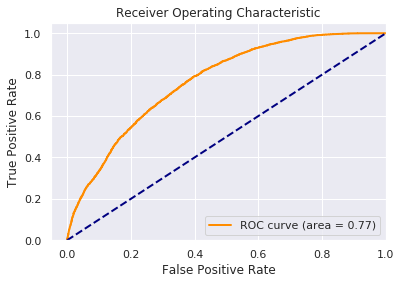

In [52]:
print('tp=',tp)
print('tn=',tn)
print('fp=',fp)
print('fn=',fn)
print('n=',n)
accuracy = (tp+tn)/n
precision = tp / (tp+fp)
recall = tp / (tp+fn)
F1 = (2*precision*recall) / (precision+recall)
tpr = tp / (tp+fn)
fpr = fp / (fp+tn)

print('accuracy =',accuracy)
print('precision =',precision)
print('recall =',recall)
print('F1 score =',F1)
print('tpr =',tpr)
print('fpr =',fpr)
from sklearn import metrics
y=df_raw.label.values
pred= df_raw.confident.values
fpr, tpr, thresholds = metrics.roc_curve(y_true=y, y_score=pred, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
print('auc=', roc_auc)

plt.figure()
linewidth = 2
plt.plot(fpr, tpr, color='darkorange',lw=linewidth, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=linewidth, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

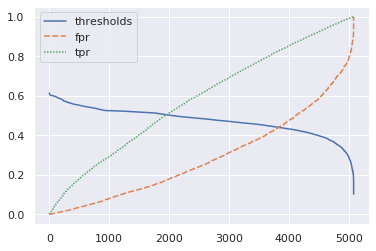

In [53]:
# red dashes, blue squares and green triangles
thresholds= np.array(thresholds.tolist()[1:])
fpr= np.array(fpr.tolist()[1:])
tpr =np.array(tpr.tolist()[1:])

d = {'thresholds': thresholds,'fpr':fpr,'tpr':tpr}
df_roc = pd.DataFrame(data=d)
fig, ax = plt.subplots()
sns.lineplot(data=df_roc)

# idx= range(len(thresholds))
# plt.plot(idx, thresholds, 'g--',idx, tpr, 'r--', idx, fpr, 'b--')
# plt.show()
# sns.lineplot(x="idx", y="fpr",ax= ax,data=df_roc,label='fpr')
# sns.lineplot(x="idx", y="tpr",ax= ax,data=df_roc,label='tpr')
# sns.lineplot(x="idx", y="thresholds",ax= ax,data=df_roc,label='thresholds')

In [247]:
df_raw.query('confident>0.6').head(20)

,title,label,prob,confident,pre_label
1,美国少年敲错门连忙道歉，房主不由分说两枪将其打死辩称是自卫,1,"[0.30041763, 0.69958234]",0.699582,1
4,达成三方交易？29＋15联盟顶级锋线赴休斯顿，哈登：无惧勇士,1,"[0.34201820000000005, 0.6579818000000001]",0.657982,1
8,日本士兵光着膀子耀武扬威，中国老兵一枪毙命，结果日本举国哀痛,1,"[0.37173873, 0.6282612]",0.628261,1
10,中国最难请的四位男星，周星驰只是一般难请，最后一位根本请不动,1,"[0.38571566, 0.61428434]",0.614284,1
15,李姐笑话：小弟弟，姐姐上班要迟到了，你让姐姐坐这辆车行吗,0,"[0.26687646, 0.73312354]",0.733124,1
23,离婚没多久，刘恺威还是原来的刘恺威，杨幂却不再是以前的杨幂,1,"[0.33713812, 0.6628618000000001]",0.662862,1
40,刘备死后，诸葛亮为何不东征为他复仇，反而恢复吴蜀联盟,0,"[0.25788996, 0.7421101]",0.742110,1
42,唐嫣曾为他险些轻生，后又求和被拒绝，如今却爱上60岁的她,1,"[0.38988492, 0.6101151]",0.610115,1
46,他是国家一级演员，二婚娶小37岁娇妻，如今73岁还在挣钱养家,1,"[0.36523387, 0.6347661]",0.634766,1
49,开心笑话：小时候爸爸妈妈总吵架，妈妈说等你考上大学我就离婚,1,"[0.24664576, 0.75335425]",0.753354,1


In [196]:
df_te=pd.read_csv('dftrain.csv')
# df_te.columns = ['idx','title','label']
print(df_te.shape)
# df_te.head(10000)

(88616, 2)


In [197]:
df_te.label.unique()
# H 0.46~0.29 1121
# M 0.27~0.21 1714
# L 0.19~~~   1233


array(['H', 'L', 'M'], dtype=object)

In [198]:
df_te['y']= 0
df_te['y'][(df_te.label=="H")]=1

df_te.head()
df_te[['title','y']].to_csv('dftrain1.csv',header=False)